In [1]:
import sys
sys.path.insert(1, '../')


In [16]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/home/llja/repos/Uni_ACS/mimiciii_sepsis/../medical_explainer.py'>

In [3]:
import pandas as pd
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

seed = 7

data = pd.read_csv('mimiciii_sepsis.csv').drop(['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID'], axis=1)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)

X = data.drop(['28 Day Death', 'In Hospital Death'], axis=1)
y = data['28 Day Death']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)

In [4]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(n_estimators=220, max_depth=7, random_state=seed).fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.8664195807997971
Average Precision: 0.8229857460690426
Accuracy: 0.789319678127286


| Step 1  ==> Calibrating model


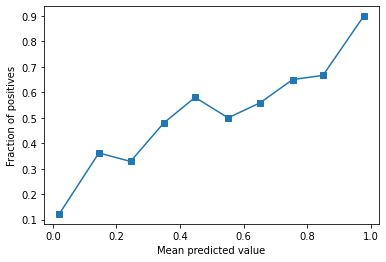

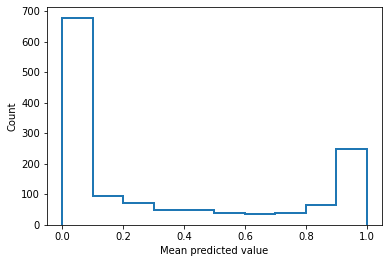

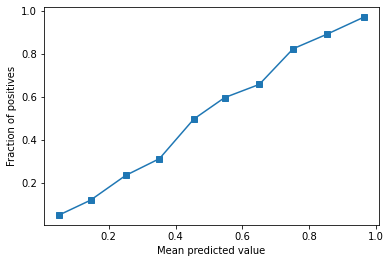

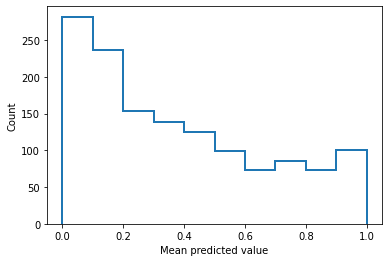

ROC AUC: 0.8664195807997971
Average Precision: 0.8229857460690426
Accuracy: 0.789319678127286
ROC AUC: 0.8721534530098864
Average Precision: 0.8290653997048896
Accuracy: 0.7995610826627652

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 26.0

Probability threshold: 0.5
Score threshold: 42.0

Probability threshold: 0.9
Score threshold: 58.0



In [17]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel')

In [7]:
explainer.score_array_list

[array([11., -7.]),
 array([-4.,  5.]),
 array([-3.,  5.]),
 array([-3.,  4.]),
 array([-5.,  3.]),
 array([-3.,  1.]),
 array([ 1., -1.,  6.]),
 array([ 2., -1.]),
 array([-2.,  1.]),
 array([ 3., -1.])]

In [8]:
explainer.breakpoints_list

[[-0.3222222222222222, 8.410828101389876, 294.66041666666666],
 [11.6, 15.454288566314101, 30.5],
 [0.008, 5.248719849964527, 153.928],
 [18.258726899383984, 72.88063943601284, 90.0],
 [0.0, 0.9373030375089514, 3.0],
 [-8.271937992540188, 192.4997909660624, 23111.0],
 [0.0, 0.47620857694695967, 1.120348572471703, 5.0],
 [0.0, 2.741774085897918, 18.290282614674197],
 [0.2, 3.4469199152619843, 17.3],
 [-151.44629137482752, 157.25498164980556, 688.0]]

In [9]:
explainer.shap_array_list

[[1.5200895428088361, -0.9579244478824746],
 [-0.6099885462630585, 0.6927547991238919],
 [-0.45866317192439593, 0.7233876816519579],
 [-0.44808059866781996, 0.6111491107487586],
 [-0.6283311741860277, 0.4108899861692078],
 [-0.3970609397226353, 0.08446878562790393],
 [0.1211356264817674, -0.14107915549971353, 0.8303772067736443],
 [0.25014018746438604, -0.1936853626523933],
 [-0.22643629017454586, 0.20312588565406928],
 [0.4238853968868893, -0.1378857191974648]]

In [10]:
explainer.shap_sd_array_list

[[2.522118465480428, 0.44414002902185556],
 [0.22944905188826117, 0.37963368577294676],
 [0.3957074809886594, 0.3725906713834319],
 [0.35260119238978743, 0.5729039056626791],
 [0.1663436337360078, 0.7500551947859361],
 [0.16890877393868114, 0.39405092732296926],
 [0.10386623755597384, 0.0654510707206616, 0.4751010534846176],
 [0.2620569670020789, 0.15099199178329772],
 [0.1906904366118162, 0.15192911506091503],
 [0.3761685237914266, 0.0775024328443512]]

In [11]:
explainer.shap_n_array_list

[[1338, 1850],
 [1672, 1516],
 [2007, 1181],
 [1848, 1340],
 [1284, 1904],
 [585, 2603],
 [2, 2782, 404],
 [1351, 1837],
 [1608, 1580],
 [831, 2357]]

In [18]:
explainer.print_calculator()

LOS<=8.41
Odds Ratio: 11.918
Confidence interval: 10.994, 12.919
8.41<LOS
Odds Ratio: 1.0

RDW<=15.45
Odds Ratio: 1.0
15.45<RDW
Odds Ratio: 3.679
Confidence interval: 3.542, 3.822

ICU_LOS<=5.25
Odds Ratio: 1.0
5.25<ICU_LOS
Odds Ratio: 3.261
Confidence interval: 3.118, 3.41

Age<=72.88
Odds Ratio: 1.0
72.88<Age
Odds Ratio: 2.884
Confidence interval: 2.752, 3.023

inotropes<=0.94
Odds Ratio: 1.0
0.94<inotropes
Odds Ratio: 2.827
Confidence interval: 2.687, 2.974

Lactate Dehydrogenase (LD)<=192.5
Odds Ratio: 1.0
192.5<Lactate Dehydrogenase (LD)
Odds Ratio: 1.619
Confidence interval: 1.535, 1.707

ICUs<=0.48
Odds Ratio: 1.3
Confidence interval: 0.912, 1.853
0.48<ICUs<=1.12
Odds Ratio: 1.0
1.12<ICUs
Odds Ratio: 2.642
Confidence interval: 2.549, 2.738

Albumin<=2.74
Odds Ratio: 1.559
Confidence interval: 1.511, 1.608
2.74<Albumin
Odds Ratio: 1.0

Phosphate<=3.45
Odds Ratio: 1.0
3.45<Phosphate
Odds Ratio: 1.537
Confidence interval: 1.493, 1.581

Haptoglobin<=157.25
Odds Ratio: 1.754
Confiden

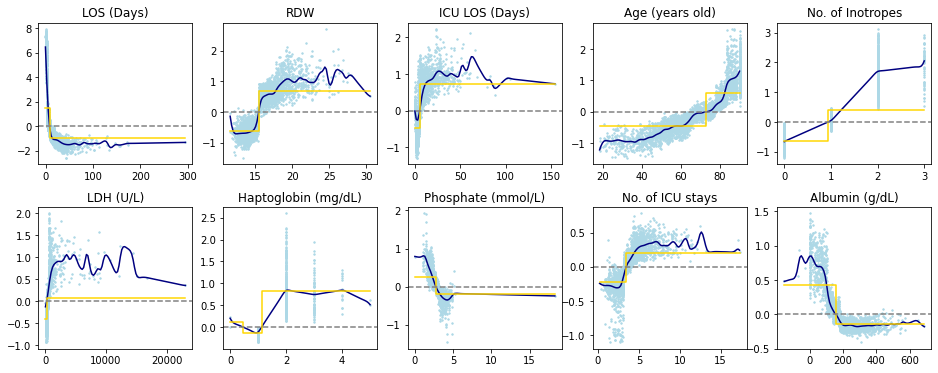

In [20]:
titles = ["LOS (Days)", "RDW", "ICU LOS (Days)", "Age (years old)", "No. of Inotropes",
         "LDH (U/L)", "Haptoglobin (mg/dL)", "Phosphate (mmol/L)", "No. of ICU stays", "Albumin (g/dL)"]

explainer.plot_calculator_features(titles)

In [21]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))

ROC AUC: 0.7445696990566637
Average Precision: 0.6462152297850027
Accuracy: 0.6986100950987564
[[786  58]
 [354 169]]


In [23]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [30]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]

    scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs)
    auprc = average_precision_score(y_test_bs, probs)
    accuracy = accuracy_score(y_test_bs, predictions)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.7591162496040544, 0.7501521544707693, 0.7680803447373395)
(0.6735832878703967, 0.6608040292489984, 0.686362546491795)
(0.7036999999999999, 0.6965068296667828, 0.710893170333217)


In [9]:
shap_values_df = pd.DataFrame(explainer.shap_values, columns=explainer.X_train.columns)

In [152]:
ordered_variables = explainer.X_train.columns[np.argsort(np.abs(explainer.shap_values.mean(0)))][::-1]

In [159]:
# from sklearn.model_selection import cross_validation
from sklearn.model_selection import cross_validate

clf = GradientBoostingClassifier(n_estimators=220, max_depth=7, random_state=seed)

scores = []

for i in range(len(ordered_variables)):
    results = cross_validate(clf, X_train[ordered_variables[:i+1]], y_train, cv=5, scoring="roc_auc")
    scores.append(np.mean(results['test_score']))
    print(ordered_variables[:i+1])
    print(results["test_score"])
    print()
    

Index(['LOS'], dtype='object')
[0.64157067 0.58560192 0.61511695 0.63754577 0.60441992]

Index(['LOS', 'ICU_LOS'], dtype='object')
[0.7068881  0.73885503 0.70038548 0.7099592  0.69373365]

Index(['LOS', 'ICU_LOS', 'ICUs'], dtype='object')
[0.73183801 0.74913268 0.73531802 0.73436552 0.70642327]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron'], dtype='object')
[0.73787461 0.77298536 0.75513882 0.74258814 0.74787112]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate'], dtype='object')
[0.76378454 0.76840131 0.77121425 0.76843812 0.74524532]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess'], dtype='object')
[0.78767009 0.79438454 0.77305829 0.77456847 0.76365729]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW'], dtype='object')
[0.78682486 0.80985571 0.77759025 0.78487289 0.78947589]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12'],
      dtype='object')
[0.79906503 0.80282336 0.78130958 0.781023

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2'],
      dtype='object')
[0.83861341 0.82823358 0.83501589 0.828957   0.85453499]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', '

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes'],
      dtype='object')
[0.84354913 0.83019222 0.84801792 0.833152   0.85294487]

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect'

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals'],
      dtype='object')
[0.85409884 0.83091108 0.83926655 0.83120619 0.84264044]

Index

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

Index(['LOS', 'ICU_LOS', 'ICUs', 'Iron', 'Phosphate', 'Base Excess', 'RDW',
       'Vitamin B12', 'inotropes', 'Osmolality, Measured',
       'Bilirubin, Indirect', 'Haptoglobin', 'PT',
       'Cholesterol Ratio (Total/HDL)', 'Age', 'Bicarbonate', 'Triglycerides',
       'Alanine Aminotransferase (ALT)', 'Calculated Bicarbonate, Whole Blood',
       '% Hemoglobin A1c', 'Magnesium', 'immunosuppresant',
       'Creatine Kinase, MB Isoenzyme', 'Asparate Aminotransferase (AST)',
       'Glucose', 'Lactate Dehydrogenase (LD)', 'Albumin', 'pO2', 'AF',
       'Amylase', 'Creatinine', 'Cholesterol, LDL, Calculated', 'Monos',
       'Calculated Total CO2', 'Anion Gap', 'C-Reactive Protein', 'Potassium',
       'Globulin', 'Protein, Total', 'Lymphocytes', 'Free Calcium', 'Chloride',
       'Sodium, Whole Blood', 'Uric Acid', 'MCHC', 'Lactate', 'Lymphs',
       'Potassium, Whole Blood', 'Lipase', 'antifungals',
       'Creatine Kinase (CK)', 'Chloride, Whole Blood', 'INR(PT)', 'Monocytes',
      

KeyboardInterrupt: 

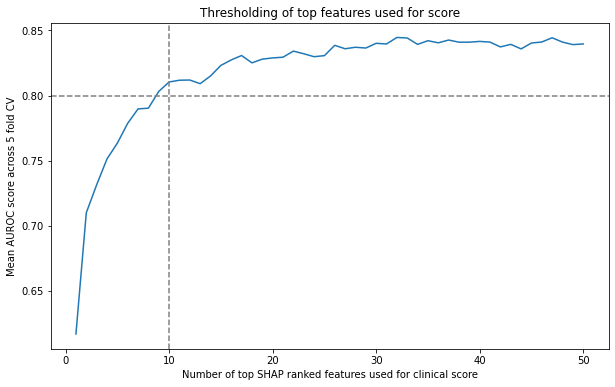

In [176]:
x = np.linspace(1, 50, 50)
plt.figure(figsize=(10, 6))
plt.plot(x, scores[:50])
plt.axhline(0.8, linestyle='--', color='gray')
plt.axvline(10, linestyle='--', color='gray')
plt.ylabel("Mean AUROC score across 5 fold CV")
plt.xlabel("Number of top SHAP ranked features used for clinical score")
plt.title("Thresholding of top features used for score")
plt.show()